# 3D plot of complexity according to frequency bin and period

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import opencc

import config

In [3]:
PERIODS = ["Oracle", "Bronze", "Seal", "Traditional", "Simplified"]
LISTDIR = lambda x: [i for i in os.listdir(x) if i != ".DS_Store"]
PMAP = {"Oracle":0,"Bronze":1,"Seal":2,"Traditional":3, "Simplified":4}


flatten = lambda l:[item for sublist in l for item in sublist]

In [5]:
complexities = pd.read_csv(config.data_file_locations["all_complexities"], index_col=0)
complexities = complexities[complexities["scale_method"] == "pad"][complexities["dataset"].isin(["hzy", "casia", "traditional"])]
cld = pd.read_csv(config.data_file_locations["cld"], index_col=0)

for freq in ["Frequency", "C1Frequency", "AdjustedFrequency", "AdjustedC1Frequency"]:
    cld[f"log {freq}"] = np.log(cld[freq])
    cld[f"{freq} bin"] = [np.floor(np.log10(i)) for i in cld[freq]]

# Keep only median complexity example for each original character
rows = []
for c, cdf in complexities.groupby("rendered_character"):
    rows.extend([pdf.sort_values(by="perimetric_complexity").iloc[int(pdf.shape[0]/2)] for _, pdf in cdf.groupby("period")])
complexities_single = pd.DataFrame(rows, columns = complexities.columns).reset_index(drop=True)

# Add complexity file's original->simplified mappings to cld data
#t2s = {row["rendered_character"]:row["simplified_character"] for _, row in complexities_single.iterrows()}
t2s = opencc.OpenCC("t2s.json")
cld["simplified_character"] = [t2s.convert(i) for i in cld["Character"]]

data = cld.merge(complexities_single.drop("rendered_character", axis=1), on=["simplified_character"]).drop("simplified_character", axis=1)
print(data.shape)

# Only keep characters that were present in the oracle stream
oracle_characters = set(data[data["period"] == "Oracle"]["Character"])
print(len(oracle_characters))
data = data[data["Character"].isin(oracle_characters)]
print(data.shape)

data.head()

<ipython-input-5-30e5a007cc79>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  complexities = complexities[complexities["scale_method"] == "pad"][complexities["dataset"].isin(["hzy", "casia", "traditional"])]


(12384, 23)
651
(3081, 23)


,Character,Pinyin,C1Type,Strokes,Frequency,C1Frequency,AdjustedFrequency,AdjustedC1Frequency,log Frequency,Frequency bin,...,AdjustedFrequency bin,log AdjustedC1Frequency,AdjustedC1Frequency bin,period,image_ID,dataset,scale_method,skeletonise_method,perimetric_complexity,pixel_complexity
0,曲,qu3,Picto,6,32.0237,183.6395,158.3171,491.4766,3.466476,1.0,...,2.0,6.197414,2.0,Bronze,B18030,hzy,pad,lee,368.281371,1382.0
1,曲,qu3,Picto,6,32.0237,183.6395,158.3171,491.4766,3.466476,1.0,...,2.0,6.197414,2.0,Oracle,J27676,hzy,pad,lee,192.729797,640.0
2,曲,qu3,Picto,6,32.0237,183.6395,158.3171,491.4766,3.466476,1.0,...,2.0,6.197414,2.0,Seal,S09470,hzy,pad,lee,358.338154,1438.0
3,曲,qu3,Picto,6,32.0237,183.6395,158.3171,491.4766,3.466476,1.0,...,2.0,6.197414,2.0,Simplified,6,casia,pad,lee,314.565583,1196.0
4,曲,qu3,Picto,6,32.0237,183.6395,158.3171,491.4766,3.466476,1.0,...,2.0,6.197414,2.0,Traditional,45,traditional,pad,lee,327.337184,1172.0


In [6]:
CMAP = {"Oracle":"red","Bronze":"orange","Seal":"green","Traditional":"blue", "Simplified":"purple"}
FREQ_TYPES = ["AdjustedC1Frequency bin", "C1Frequency bin"]

In [7]:
# Make sure C1 bins have enough characters in them
MIN_BIN_SIZE = 5
for freq in FREQ_TYPES:
    for f, fdf in data.sort_values(by=freq).groupby(freq):
        print(freq, f, len(fdf["Character"].unique()))
        
# Merge -1 and 0 bin for AdjustedC1Frequency
data["AdjustedC1Frequency bin"] = data["AdjustedC1Frequency bin"].apply(lambda x: -1 if x == -2 else x)

# Merge 5 and 4 bin for AdjustedC1Frequency
data["AdjustedC1Frequency bin"] = data["AdjustedC1Frequency bin"].apply(lambda x: 4 if x == 5 else x)

# Merge -1 and 0 bin for AdjustedC1Frequency
data["C1Frequency bin"] = data["AdjustedC1Frequency bin"].apply(lambda x: -1 if x == -2 else x)

# Merge 3 and 4 bin for AdjustedC1Frequency
data["C1Frequency bin"] = data["AdjustedC1Frequency bin"].apply(lambda x: 3 if x == 4 else x)

AdjustedC1Frequency bin -2.0 1
AdjustedC1Frequency bin -1.0 18
AdjustedC1Frequency bin 0.0 63
AdjustedC1Frequency bin 1.0 184
AdjustedC1Frequency bin 2.0 244
AdjustedC1Frequency bin 3.0 114
AdjustedC1Frequency bin 4.0 25
AdjustedC1Frequency bin 5.0 2
C1Frequency bin -2.0 3
C1Frequency bin -1.0 19
C1Frequency bin 0.0 70
C1Frequency bin 1.0 206
C1Frequency bin 2.0 273
C1Frequency bin 3.0 77
C1Frequency bin 4.0 3


<ipython-input-8-a8799f4786b1>:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['$≤0.1$', '$1$', '$10$', '$100$', '$1000$', '$≥10000$', ''])
<ipython-input-8-a8799f4786b1>:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['$≤0.1$', '$1$', '$10$', '$100$', '$≥1000$', ''])


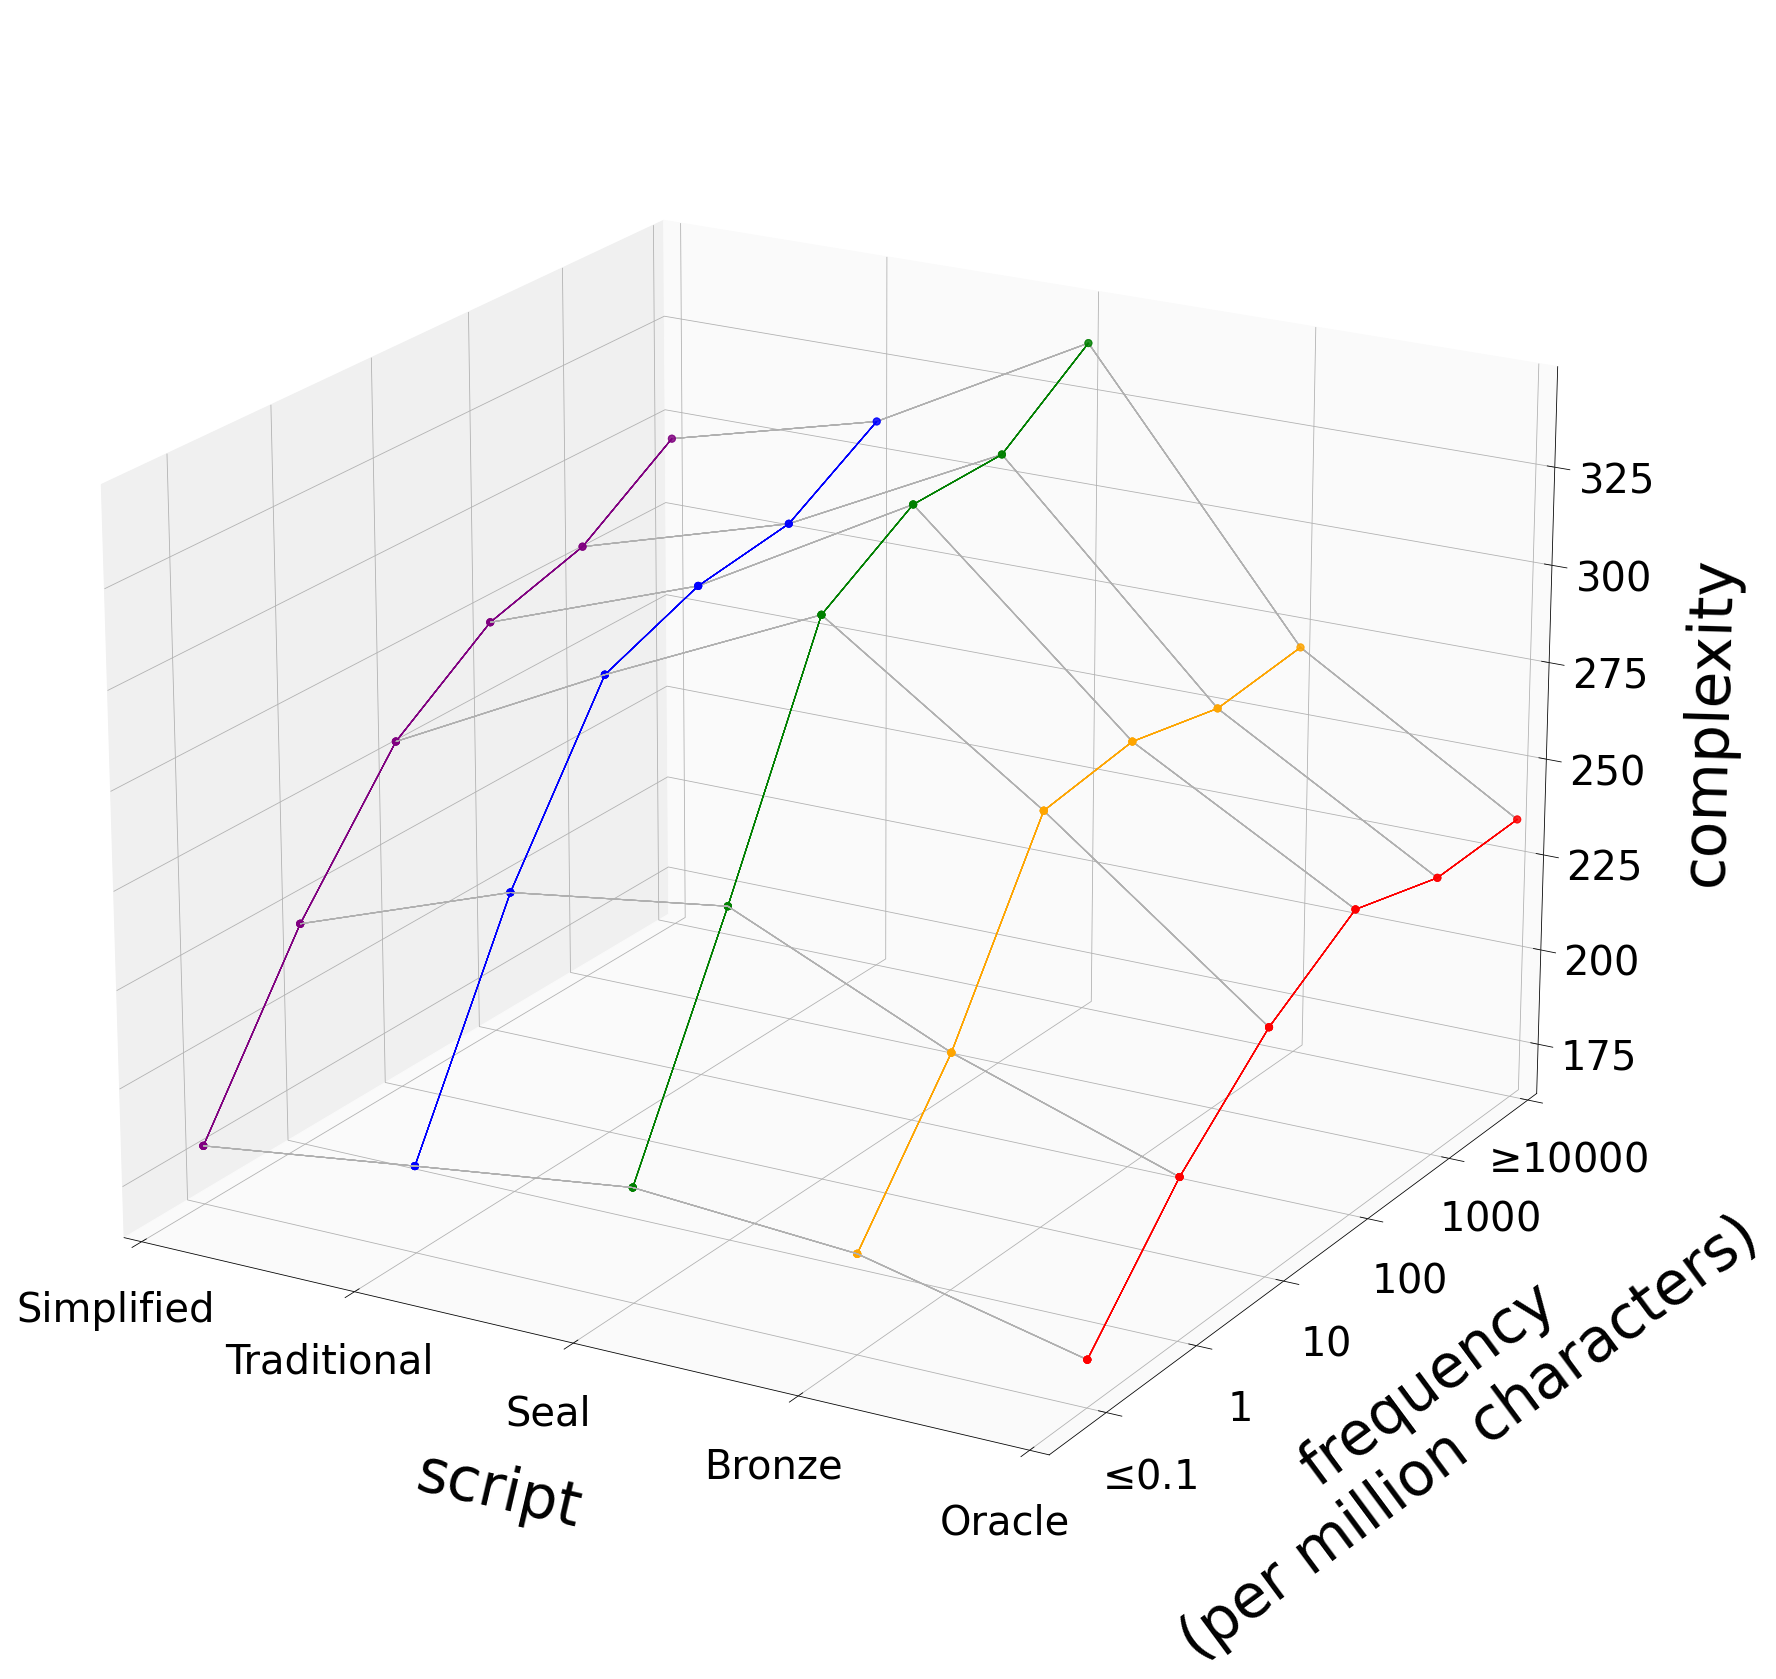

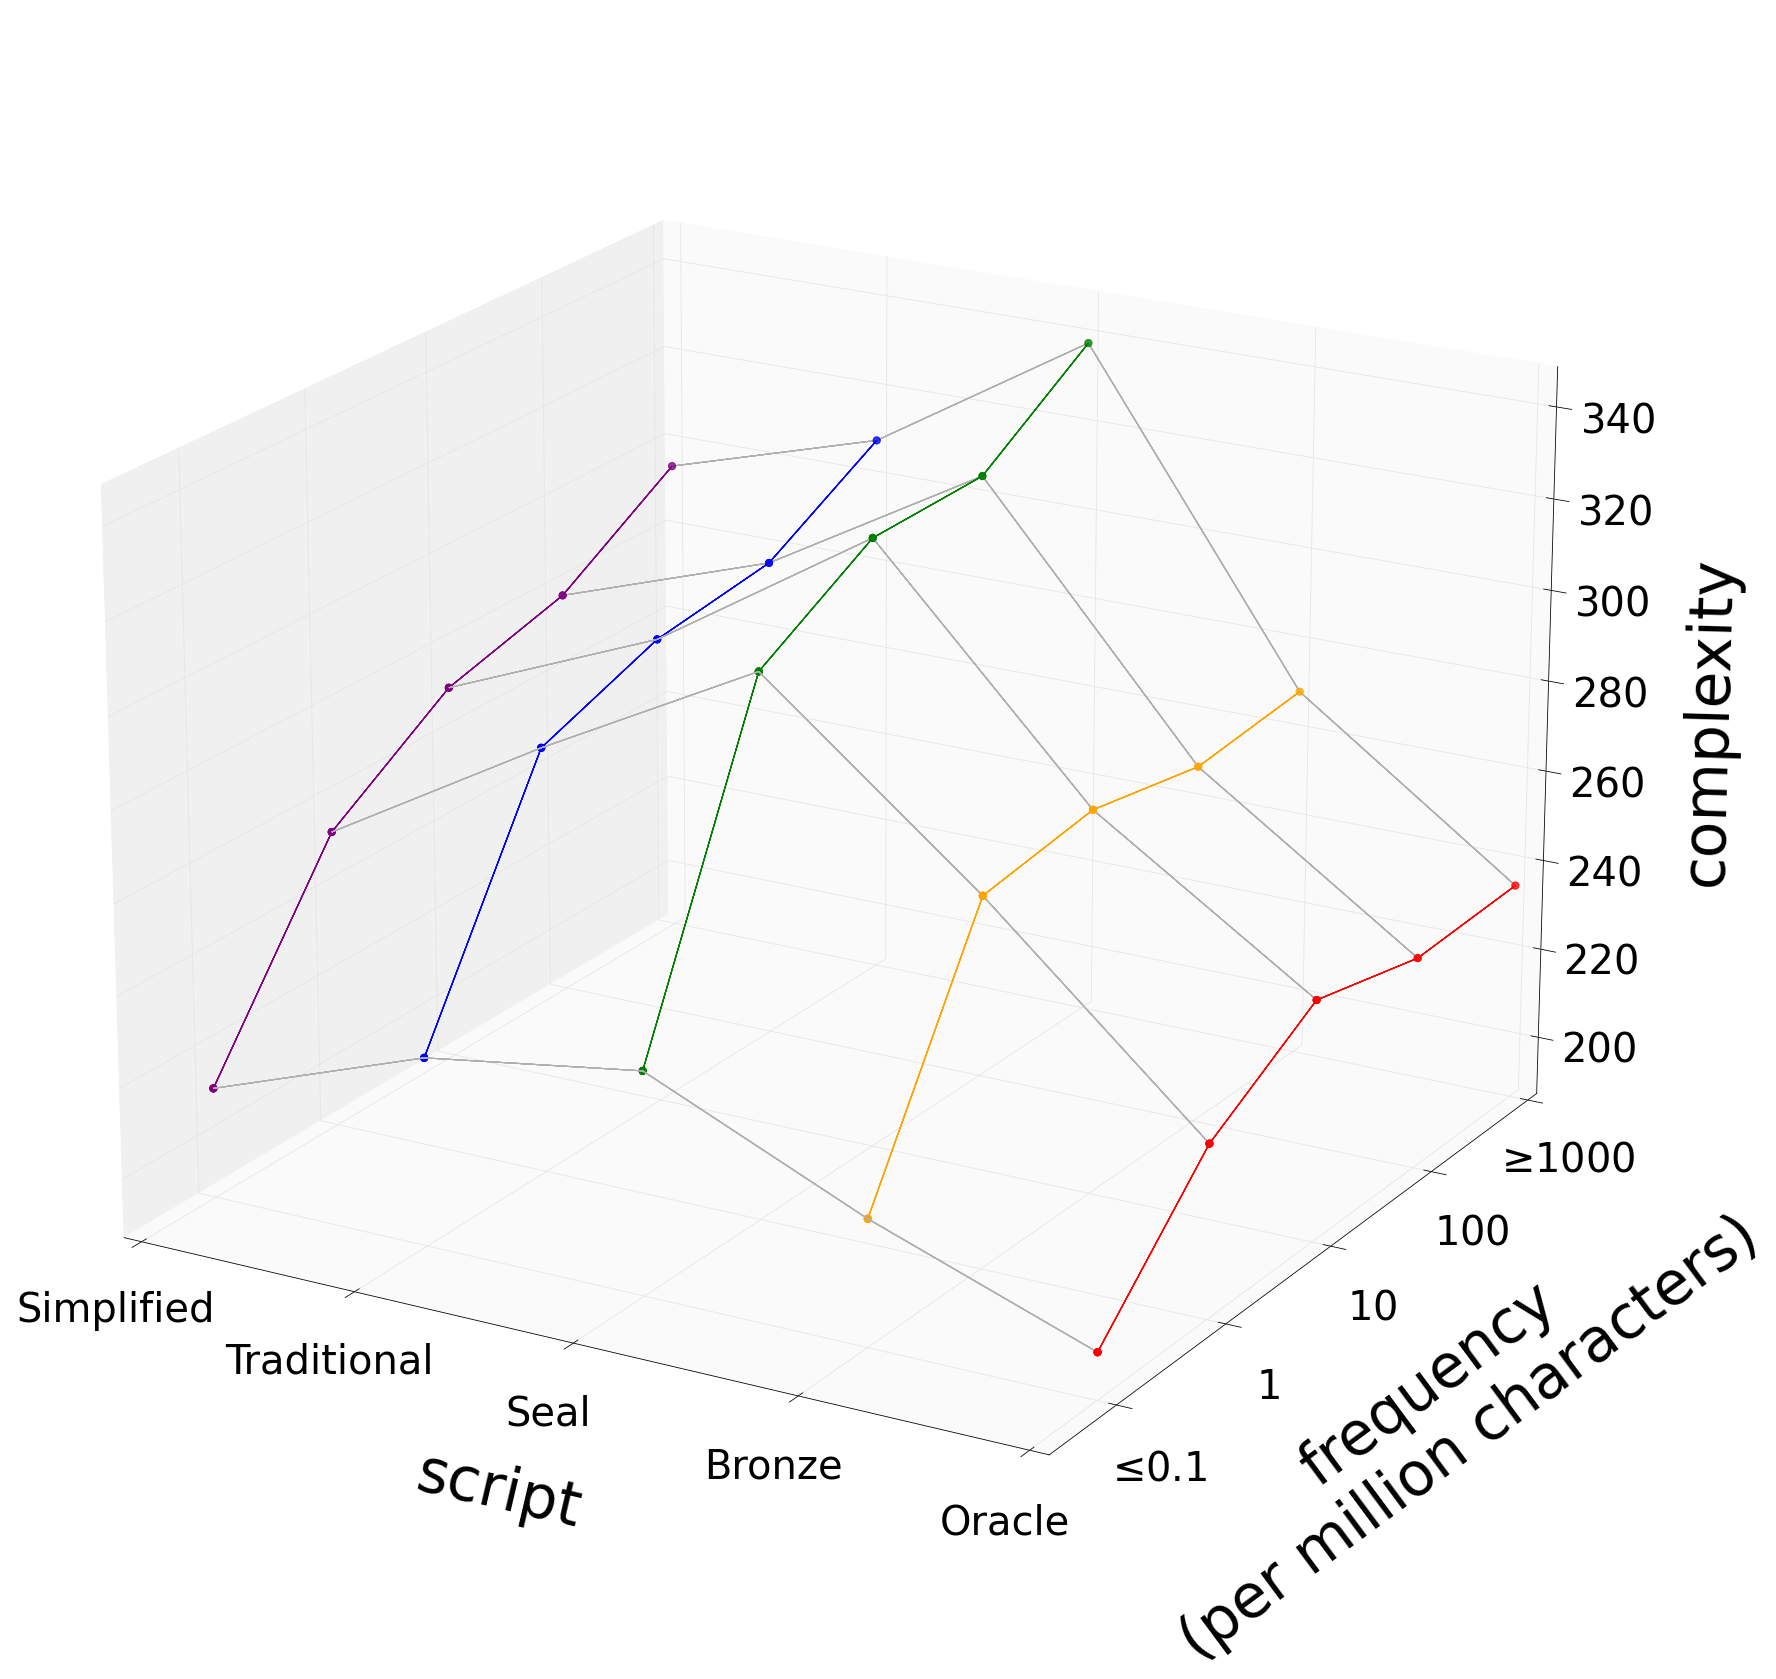

In [8]:
for freq in ["AdjustedC1Frequency bin", "C1Frequency bin"]:
    fig, ax = plt.subplots(figsize=(30,30), subplot_kw={'projection': '3d'})
    plt.rcParams['grid.color'] = "#E5E5E5"

    rows = []
    for lb, lbdata in data.groupby(freq):
        for period in PERIODS:
            rows.append((lb, period, np.mean(lbdata[lbdata["period"]==period]["perimetric_complexity"])))
            
    lbcdf = pd.DataFrame(rows, columns=[freq, "period", "average complexity"])
    lbcdf["period rank"] = [PMAP[i] for i in lbcdf["period"]]
    
    #ax = fig.add_subplot(1, 1, 1, projection='3d')
    
    for f,fdata in lbcdf.sort_values(by=freq).groupby(freq):
        fdf = fdata.sort_values(by="period rank")
        for i in range(0, fdf.shape[0]-1):
            ax.plot_wireframe(fdf["period rank"],fdf[freq].iloc[0]*np.ones(fdf.shape[0]),np.array([fdf["average complexity"],fdf["average complexity"]]),color="#b0b0b0",linewidth=1)
            
    for p,pdata in lbcdf.sort_values(by="period rank").groupby("period"):
        pdf = pdata.sort_values(by=freq)
        for i in range(0, pdf.shape[0]-1):
            ax.plot_wireframe(pdf["period rank"].iloc[0]*np.ones(pdf.shape[0]),pdf[freq],np.array([pdf["average complexity"],pdf["average complexity"]]),color=CMAP[p],linewidth=1)
            ax.scatter3D(pdf["period rank"].iloc[0]*np.ones(pdf.shape[0]),pdf[freq],pdf["average complexity"],color=CMAP[p],s=50)
                
    ax.set_xlabel('script')
    ax.set_ylabel('frequency\n(per million characters)')
    ax.set_zlabel('complexity')
    
    ax.xaxis.set_ticks(np.arange(0,len(PERIODS),1))

    if freq == "C1Frequency bin":
        ax.set_yticklabels(['$≤0.1$', '$1$', '$10$', '$100$', '$≥1000$', ''])
    else:
        ax.set_yticklabels(['$≤0.1$', '$1$', '$10$', '$100$', '$1000$', '$≥10000$', ''])
    ax.set_xticklabels(['Oracle','Bronze','Seal','Traditional','Simplified'])

    # if freq != "C1Frequency bin":
    #     ax.set_ylim(0,5)
    #     ax.invert_yaxis()
    #     ax.set_ylim(5,-1)
    
    ax.xaxis.label.set_fontweight("medium")
    ax.yaxis.label.set_fontweight("medium")
    ax.zaxis.label.set_fontweight("medium")

    ax.view_init(20,-60)
    ax.w_xaxis.set_pane_color((240/255,240/255,240/255,1))
    ax.w_yaxis.set_pane_color((250/255,250/255,250/255,1))
    ax.w_zaxis.set_pane_color((250/255,250/255,250/255,1))

    ax.xaxis.labelpad = 90
    ax.yaxis.labelpad = 110
    ax.zaxis.labelpad = 80
    
    ax.tick_params(axis="both", labelsize=40,pad=30)
        
    ax.xaxis.label.set_fontsize(60)
    ax.yaxis.label.set_fontsize(60)
    ax.zaxis.label.set_fontsize(60)

    #plt.xticks(rotation=0)
    if freq == "AdjustedC1Frequency bin":
        ax.set_ylim(4.5,-1)
        ax.set_yticks(range(4,-2,-1))
    else:
        ax.set_ylim(3.5,-1)
        ax.set_yticks(range(3,-2,-1))
    ax.set_xlim(4,0)
        
    plt.savefig(f"figures/fig4_{freq.replace(' bin', '')}.png", dpi=400)

In [44]:
for freq in FREQ_TYPES:
    for f, fdf in data.sort_values(by=freq).groupby(freq):
        print(freq, f, len(fdf["Character"].unique()))

AdjustedFrequency bin -2.0 29
AdjustedFrequency bin -1.0 78
AdjustedFrequency bin 0.0 150
AdjustedFrequency bin 1.0 180
AdjustedFrequency bin 2.0 137
AdjustedFrequency bin 3.0 58
AdjustedFrequency bin 4.0 19
AdjustedC1Frequency bin -1.0 19
AdjustedC1Frequency bin 0.0 63
AdjustedC1Frequency bin 1.0 184
AdjustedC1Frequency bin 2.0 244
AdjustedC1Frequency bin 3.0 114
AdjustedC1Frequency bin 4.0 27
Frequency bin -2.0 31
Frequency bin -1.0 86
Frequency bin 0.0 170
Frequency bin 1.0 210
Frequency bin 2.0 119
Frequency bin 3.0 31
Frequency bin 4.0 4
C1Frequency bin -1.0 19
C1Frequency bin 0.0 63
C1Frequency bin 1.0 184
C1Frequency bin 2.0 244
C1Frequency bin 3.0 141
